In [1]:
import torch, re
import torch.utils.data as data_utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
def load_data(tokenizer):
    ds = []
    # Read from src
    with open('data/train_set.fasta') as f:
        lines = f.read().split(">")[1:]
        ds = [0]*len(lines)
        for i, line in enumerate(tqdm(lines)):
            seq, sep = line.strip().split("\n")[1:]
            seq = " ".join(seq)
            sep = re.sub("S|T|L|P", "0", sep) # simplify to SP existance
            sep = re.sub("I|M|O",   "1", sep) # simplify to SP non-existance
            sep = 1. if "0" in sep else 0.
            ds[i] = {
                'seq': seq,
                'sep': sep,
                'tokenized': tokenizer(seq, padding='max_length', max_length=72, return_tensors="pt")
            }
    # Tokenize data
    # ds = [dict(item, **{'tokenized':tokenizer(item['seq'], padding='max_length', max_length=72, return_tensors="pt")}) for item in ds]
    return ds

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")

/home/andrebw/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-12 19:28:40.798343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 19:28:40.798448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 19:28:40.829799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 19:28:40.898975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is opt

In [9]:
text = "E U K A R Y A [SEP] M A E G I"
tokens = tokenizer(text)
tokenizer.convert_ids_to_tokens(tokens['input_ids'])

['[CLS]',
 'E',
 'U',
 'K',
 'A',
 'R',
 'Y',
 'A',
 '[SEP]',
 'M',
 'A',
 'E',
 'G',
 'I',
 '[SEP]']

In [5]:
ds = load_data(tokenizer)
for i in tqdm(range(len(ds))):  # Flatten data and move to device
    ds[i]['tokenized'] = {k: v.flatten().to(device) 
        for k,v in ds[i]['tokenized'].items()}
set([d['tokenized']['input_ids'].shape for d in ds])

  0%|          | 0/20290 [00:00<?, ?it/s]

100%|██████████| 20290/20290 [00:04<00:00, 4703.82it/s]


{torch.Size([72])}

In [6]:
n_neg = len(list(filter(lambda x : x['sep'] == 0, ds)))
n_pos = len(list(filter(lambda x : x['sep'] == 1, ds)))
neg_weight = (n_neg + n_pos) / n_neg
pos_weight = (n_neg + n_pos) / n_pos
n_neg, neg_weight, n_pos, pos_weight

(15625, 1.29856, 4665, 4.34941050375134)

In [7]:
# Create dataset batches
dataset = data_utils.DataLoader(ds, batch_size=2, shuffle=True)
tokens = next(iter(dataset))['tokenized']#.squeeze(1)
tokens['input_ids'].shape

torch.Size([2, 72])

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.functional.binary_cross_entropy_with_logits
epochs = 10
batch_size = 12

In [13]:
loss_log = []
model.train()
for epoch in range(epochs):
    dataset = data_utils.DataLoader(ds, batch_size=batch_size, shuffle=True)
    for i, batch in enumerate(tqdm(dataset)):
        loss_weights = torch.tensor([neg_weight if x == 0 else pos_weight for x in batch['sep']]).to(device)
        optimizer.zero_grad()
        logits = model.forward(**batch['tokenized']).logits
        y_pred = torch.argmax(logits, dim=1).double().requires_grad_()

        loss = criterion(input=y_pred, target=batch['sep'].to(device).requires_grad_(), weight=loss_weights)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.cpu().detach().item())
        if (i+1) % (len(ds) // 20) == 0:
            print(np.mean(loss_log))

  0%|          | 0/1691 [00:00<?, ?it/s]

 59%|█████▉    | 1005/1691 [12:09<08:17,  1.38it/s]


KeyboardInterrupt: 

In [ ]:
torch.nn.Embedding(4)

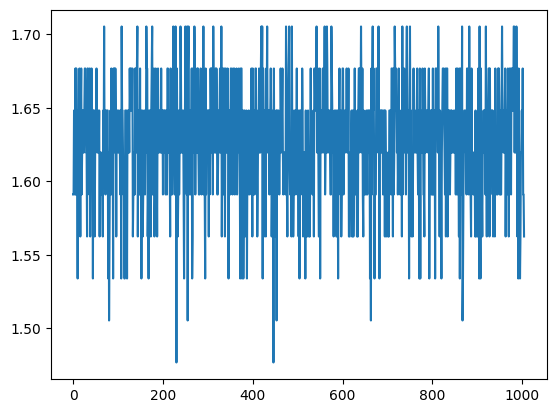

In [14]:
plt.plot(loss_log)

In [ ]:
import pickle
with open("log/loss.log", "wb") as file:
    pickle.dump(loss_log, file)
with open("log/loss.log", "rb") as file:
    loss_log = pickle.load(file)

In [ ]:
torch.save(model.state_dict(), "model/model.pth")